### 1. 升级boto3, sagemaker python sdk

In [ ]:
!pip install --upgrade boto3 sagemaker

In [6]:
#导入对应的库

import re
import os
import json
import uuid

import numpy as np
import pandas as pd
from time import gmtime, strftime


import boto3
import sagemaker

from sagemaker import get_execution_role,session
from sagemaker import Model, image_uris, serializers, deserializers

role = get_execution_role()
sage_session = session.Session()
bucket = sage_session.default_bucket()
aws_region = boto3.Session().region_name
sts_client = boto3.client('sts')
account_id = sts_client.get_caller_identity()['Account']
print(f'account id:{account_id}')

print(f'sagemaker sdk version: {sagemaker.__version__}\nrole:  {role}  \nbucket:  {bucket}')

account id:687912291502
sagemaker sdk version: 2.244.2
role:  arn:aws:iam::687912291502:role/service-role/AmazonSageMaker-ExecutionRole-20211013T113123  
bucket:  sagemaker-us-west-2-687912291502


### 2. 编译docker image (comfyui-inference)

In [2]:
## You should change below region code to the region you used, here sample is use us-west-2
!aws ecr get-login-password --region us-west-2 | docker login --username AWS --password-stdin 763104351884.dkr.ecr.us-west-2.amazonaws.com

WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded


In [ ]:
!./build_and_push_async.sh docker/dockerfile-latest latest

In [7]:
!touch dummy
!tar czvf model.tar.gz dummy
assets_dir = 's3://{0}/{1}/assets/'.format(bucket, 'stablediffusion')
model_data = 's3://{0}/{1}/assets/model.tar.gz'.format(bucket, 'stablediffusion')
!aws s3 cp model.tar.gz $assets_dir
!rm -f dummy model.tar.gz

dummy
upload: ./model.tar.gz to s3://sagemaker-us-west-2-687912291502/stablediffusion/assets/model.tar.gz


#### 3.1 创建dummy model_data 文件(真正的模型使用code/infernece.py进行加载)

In [4]:
!aws s3 ls s3://sagemaker-us-west-2-687912291502/models/flux

                           PRE flux/


### 4. deploy(ssh debug inference）

In [8]:
env={
        's3_bucket': bucket,
        #'CLIP_MODEL_PATH': "s3://sagemaker-us-west-2-687912291502/models/clip",
        #'MODEL_PATH': "s3://sagemaker-us-west-2-687912291502/models/flux",
        #'CONTROLNET_MODEL_PATH':"s3://sagemaker-us-west-2-687912291502/models/controlnet",
        #'OTHER_MODEL_PATHS':"sams|s3://sagemaker-us-west-2-687912291502/models/sam;grounding-dino|s3://sagemaker-us-west-2-687912291502/models/groundingdino"
    }

In [9]:
container=f"{account_id}.dkr.ecr.{aws_region}.amazonaws.com/comfyui-inference:latest"
print(container)

687912291502.dkr.ecr.us-west-2.amazonaws.com/comfyui-inference:latest


In [10]:
from sagemaker_ssh_helper.wrapper import SSHModelWrapper
import sagemaker
from sagemaker.pytorch import PyTorchModel
from sagemaker.async_inference.async_inference_config import AsyncInferenceConfig


#container="687912291502.dkr.ecr.us-west-2.amazonaws.com/comfyui-inference:latest"
model = PyTorchModel(image_uri=container, 
              model_data=model_data, 
              role=role,
              env=env,
              dependencies=[SSHModelWrapper.dependency_dir()])

In [11]:
instance_type = "ml.g6e.2xlarge"
from sagemaker.async_inference.async_inference_config import AsyncInferenceConfig
from sagemaker_ssh_helper.wrapper import SSHModelWrapper

endpoint_name = sagemaker.utils.name_from_base("comfyui-byoc")
async_config = AsyncInferenceConfig(
    output_path=f's3://sagemaker-{aws_region}-{account_id}/async-output',  # 替换为您的S3输出路径
)

ssh_wrapper = SSHModelWrapper.create(model, connection_wait_time_seconds=0)
model.deploy(initial_instance_count=1,
             instance_type=instance_type,
             endpoint_name=endpoint_name,
             container_startup_health_check_timeout=800,
             async_inference_config=async_config
            )
# our requests and responses will be in json format so we specify the serializer and the deserializer

#print(f"To connect over SSH run: sm-local-ssh-training connect {ssh_wrapper.training_job_name()}")


[06/28/25 22:15:15] INFO     Turning on SSH to endpoint for model <class                             ]8;id=680035;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker_ssh_helper/wrapper.py\wrapper.py]8;;\:]8;id=773344;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker_ssh_helper/wrapper.py#351\351]8;;\
                             'sagemaker.pytorch.model.PyTorchModel'>                                               

                    INFO     Passing 'AID**************E6OJ' as a value of the SSHOwner tag of an SSM ]8;id=142734;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker_ssh_helper/wrapper.py\wrapper.py]8;;\:]8;id=335619;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker_ssh_helper/wrapper.py#88\88]8;;\
                             managed instance                                                                      

                    INFO     Creating model with name: comfyui-inference-2025-06-28-22-15-15-594    ]8;id=289530;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=958692;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4105\4105]8;;\

[06/28/25 22:15:16] INFO     Creating endpoint-config with name                                     ]8;id=858785;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=305150;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#6030\6030]8;;\
                             comfyui-byoc-2025-06-28-22-15-15-167                                                  

                    INFO     Creating endpoint with name comfyui-byoc-2025-06-28-22-15-15-167       ]8;id=177180;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=784651;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4852\4852]8;;\

--------------------------!

In [12]:
instance_ids = ssh_wrapper.get_instance_ids(timeout_in_sec=900)  # <--NEW-- 
print(f"To connect over SSM run: aws ssm start-session --target {instance_ids[0]}")

[06/28/25 22:28:52] INFO     Resolving endpoint instance IDs through CloudWatch logs                 ]8;id=621346;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker_ssh_helper/wrapper.py\wrapper.py]8;;\:]8;id=968272;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker_ssh_helper/wrapper.py#361\361]8;;\

                    INFO     Remote endpoint logs are at                                             ]8;id=350359;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker_ssh_helper/wrapper.py\wrapper.py]8;;\:]8;id=443705;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker_ssh_helper/wrapper.py#362\362]8;;\
                             https://us-west-2.console.aws.amazon.com/cloudwatch/home?region=us-west               
                             -2#logsV2:log-groups/log-group/$252Faws$252Fsagemaker$252FEndpoints$252               
                             Fcomfyui-byoc-2025-06-28-22-15-15-167                                                 

                    INFO     Endpoint metadata is at                                                 ]8;id=866349;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker_ssh_helper/wrapper.py\wrapper.py]8;;\:]8;id=56472;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker_ssh_helper/wrapper.py#363\363]8;;\
                             https://us-west-2.console.aws.amazon.com/sagemaker/home?region=us-west-               
                             2#/endpoints/comfyui-byoc-2025-06-28-22-15-15-167                                     

                    INFO     Endpoint config metadata is at                                          ]8;id=400470;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker_ssh_helper/wrapper.py\wrapper.py]8;;\:]8;id=967468;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker_ssh_helper/wrapper.py#364\364]8;;\
                             https://us-west-2.console.aws.amazon.com/sagemaker/home?region=us-west-               
                             2#/endpointConfig/comfyui-byoc-2025-06-28-22-15-15-167                                

                    INFO     Model metadata is at                                                    ]8;id=796730;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker_ssh_helper/wrapper.py\wrapper.py]8;;\:]8;id=89607;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker_ssh_helper/wrapper.py#365\365]8;;\
                             https://us-west-2.console.aws.amazon.com/sagemaker/home?region=us-west-               
                             2#/models/comfyui-inference-2025-06-28-22-15-15-594                                   

                    INFO     Querying SSM instance IDs for endpoint comfyui-byoc-2025-06-28-22-15-15-167  ]8;id=7435;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker_ssh_helper/log.py\log.py]8;;\:]8;id=504510;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker_ssh_helper/log.py#61\61]8;;\

                    INFO     Using AWS Region: us-west-2                                              ]8;id=848034;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker_ssh_helper/manager.py\manager.py]8;;\:]8;id=972495;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker_ssh_helper/manager.py#30\30]8;;\

[06/28/25 22:28:53] INFO     Got preliminary SSM instance IDs: ['mi-0c2292c899dd62cf4']               ]8;id=997858;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker_ssh_helper/manager.py\manager.py]8;;\:]8;id=974856;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker_ssh_helper/manager.py#41\41]8;;\

                    INFO     Got final SSM instance IDs: ['mi-0c2292c899dd62cf4']                     ]8;id=560177;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker_ssh_helper/manager.py\manager.py]8;;\:]8;id=878442;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker_ssh_helper/manager.py#51\51]8;;\

To connect over SSM run: aws ssm start-session --target mi-0c2292c899dd62cf4


## 4.测试

#### 4.1 测试辅助方法 

In [13]:
endpoint_name="comfyui-byoc-2025-06-28-22-15-15-167"

In [36]:
import time
import datetime
import uuid
import io
import traceback
from PIL import Image
import boto3
import json
import matplotlib.pyplot as plt
from PIL import Image

s3_client = boto3.client('s3')
s3_resource = boto3.resource('s3')

def get_bucket_and_key(s3uri):
    pos = s3uri.find('/', 5)
    bucket = s3uri[5 : pos]
    key = s3uri[pos + 1 : ]
    return bucket, key


def predict_async(endpoint_name,payload):
    runtime_client = boto3.client('runtime.sagemaker')
    input_file=str(uuid.uuid4())+".json"
    s3_client = boto3.resource('s3')
    s3_object = s3_client.Object(bucket, f'stablediffusion/asyncinvoke/input/{input_file}')
    payload_data = json.dumps(payload).encode('utf-8')
    s3_object.put( Body=bytes(payload_data))
    input_location=f's3://{bucket}/stablediffusion/asyncinvoke/input/{input_file}'
    print(f'input_location: {input_location}')
    response = runtime_client.invoke_endpoint_async(
        EndpointName=endpoint_name,
        InputLocation=input_location
    )
    result =response.get("OutputLocation",'')
    return wait_async_result(result)


def s3_object_exists(s3_path):
    """
    s3_object_exists
    """
    try:
        s3 = boto3.client('s3')
        base_name=os.path.basename(s3_path)
        _,ext_name=os.path.splitext(base_name)
        bucket,key=get_bucket_and_key(s3_path)
        
        s3.head_object(Bucket=bucket, Key=key)
        return True
    except Exception as ex:
        print("job is not completed, waiting...")   
        return False

def get_result(output_location):
    try:
        bucket, key = get_bucket_and_key(output_location)
        #print("here2===",bucket,key)
        obj = s3_resource.Object(bucket, key)
        body = obj.get()['Body'].read().decode('utf-8') 
        predictions = json.loads(body)
        print("async result:",predictions["prediction"][-1])
        return predictions
    except Exception as e:
        print("get result execption...",e)   


def show_image(result):
    try:
        # 获取最后一个图像
        image = result['prediction'][-1]
        bucket, key = get_bucket_and_key(image)
        obj = s3_client.get_object(Bucket=bucket, Key=key)
        bytes = obj['Body'].read()
        image = Image.open(io.BytesIO(bytes))
        
        # 将图像大小调整为 50%
        half = 0.5
        out_image = image.resize([int(half * s) for s in image.size])
        out_image.show()

    except Exception as e:
        print("result is not completed, waiting…")
        


def show_gifs(result):
    import base64
    from IPython import display
    try:
        predictions = result['prediction']
        s3_file_path = predictions[0]
        print("s3 generated gifs path is {}".format(s3_file_path))
        bucket_name, key = get_bucket_and_key(s3_file_path)
        timestamp = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        local_file_path="./ComfyUI_"+timestamp+".gif"
        s3_client.download_file(bucket_name, key, local_file_path)
        with open(local_file_path, 'rb') as fd:
            b64 = base64.b64encode(fd.read()).decode('ascii')
        return display.HTML(f'<img src="data:image/gif;base64,{b64}" />')
    except Exception as e:
        print(e)
        print("result is not completed, waiting...")

        
def wait_async_result(output_location,timeout=60):
    current_time=0
    result = None
    while current_time<timeout:
        if s3_object_exists(output_location):
            print("have async result",output_location)
            result=get_result(output_location)
            break
        else:
            time.sleep(5)
    return result

def check_sendpoint_status(endpoint_name,timeout=600):
    client = boto3.client('sagemaker')
    current_time=0
    while current_time<timeout:
        client = boto3.client('sagemaker')
        try:
            response = client.describe_endpoint(
            EndpointName=endpoint_name
            )
            if response['EndpointStatus'] !='InService':
                raise Exception (f'{endpoint_name} not ready , please wait....')
        except Exception as ex:
            print(f'{endpoint_name} not ready , please wait....')
            time.sleep(10)
        else:
            status = response['EndpointStatus']
            print(f'{endpoint_name} is ready, status: {status}')
            break

#### 5. 测试flux kontext dev workflow

In [38]:
import uuid
import json
import base64
import random

def image_to_base64(image_path):
    try:
        with open(image_path, "rb") as image_file:
            # 读取图像文件
            image_data = image_file.read()
            # 将图像数据转换为Base64编码
            base64_encoded = base64.b64encode(image_data).decode('utf-8')
            return base64_encoded
    except IOError:
        print(f"无法读取文件: {image_path}")
        return None

prompt_json_file="./sample_workflows/flux_kontext_dev_workflow.json"
image_path = "./images/model_1.png"
base64_string = image_to_base64(image_path)

prompt_text=""
with open(prompt_json_file) as f:
    prompt_text = json.load(f)


prompt_text['197']['inputs']['image'] = base64_string
prompt_text['196']['inputs']['text'] = """write 'I love chengdu' on the t-shirt of the girl,
                                         keeping the same engraved chrome style, lighting, perspective, 
                                         and position on the hardware"""
prompt_text['31']['inputs']['seed'] = random.randint(0, 99999999998)


client_id = str(uuid.uuid4())
payload={
     "client_id":client_id,
     "prompt": prompt_text,
     "inference_type":"text2img",
     "method":"queue_prompt"
}
result = predict_async(endpoint_name,payload)

input_location: s3://sagemaker-us-west-2-687912291502/stablediffusion/asyncinvoke/input/fe572831-22e3-446b-8e00-a0552acaa707.json
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...
job is not completed, waiting...
have async result s3://sagemaker-us-west-2-687912291502/async-output/3de7121d-a026-4df0-b2f3-26cd07cdbe7c.out
async result: s3://sagemaker-us-west-2-687912291502/comfyui_output/images/060c783d-016a-4e5c-ac00-7f9537db58fc.jpg


In [39]:
result

{'prediction': ['s3://sagemaker-us-west-2-687912291502/comfyui_output/images/060c783d-016a-4e5c-ac00-7f9537db58fc.jpg']}

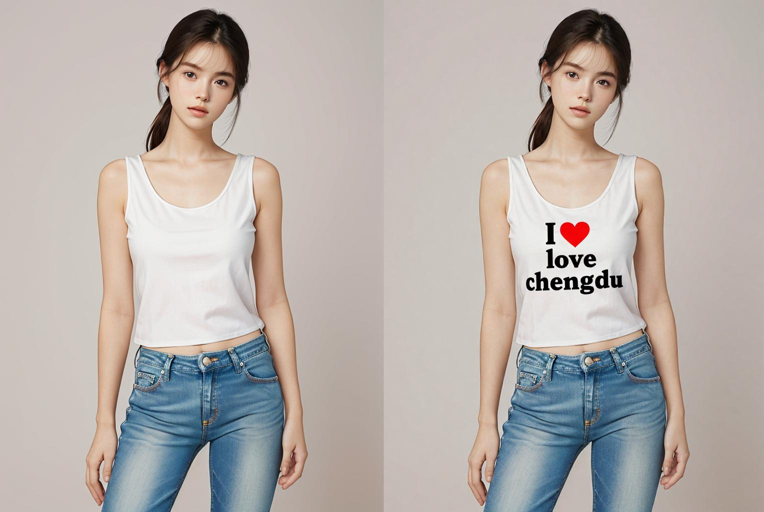

In [40]:
show_image(result)

* 测试图像翻译

In [ ]:
endpoint_name="comfyui-byoc-2025-05-23-10-18-03-139"

[06/28/25 14:14:17] ERROR    Task was destroyed but it is pending!                              ]8;id=470675;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/asyncio/base_events.py\base_events.py]8;;\:]8;id=640239;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/asyncio/base_events.py#1758\1758]8;;\
                             task: <Task pending name='Task-2'                                                     
                             coro=<Kernel.poll_control_queue() running at                                          
                             /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages                    
                             /ipykernel/kernelbase.py:285> wait_for=<Future finished                               
                             result=<Future at 0x...state=pending>>                                                
                             cb=[_chain_future.<locals>._call_set_state() at                                       
                             /home/ec2-user/anaconda3/envs/python3/lib/python3.10/asyncio/futur                    
                             es.py:392]>                                                                           

In [88]:
source_img = "./textract_demo_015.png"

import uuid
import json
import base64

def image_to_base64(image_path):
    try:
        with open(image_path, "rb") as image_file:
            # 读取图像文件
            image_data = image_file.read()
            # 将图像数据转换为Base64编码
            base64_encoded = base64.b64encode(image_data).decode('utf-8')
            return base64_encoded
    except IOError:
        print(f"无法读取文件: {image_path}")
        return None

# 使用你提供的图像路径
image_path = "./textract_demo_015.png"
base64_string = image_to_base64(image_path)


prompt_text=""
with open(prompt_json_file) as f:
    prompt_text = json.load(f)

prompt_text['81']['inputs']['image']= base64_string

client_id = str(uuid.uuid4())
payload={
     "client_id":client_id,
     "prompt": prompt_text,
     "inference_type":"text2img",
     "method":"queue_prompt"
}
result = predict_async(endpoint_name,payload)

input_location: s3://sagemaker-us-west-2-687912291502/stablediffusion/asyncinvoke/input/39bc57de-225e-403f-94f0-8e9d3d2e6f39.json
job is not completed, waiting...
job is not completed, waiting...
have async result s3://sagemaker-us-west-2-687912291502/async-output/9616f83b-1673-423c-8e32-1d3b69fcd724.out
async result: s3://sagemaker-us-west-2-687912291502/comfyui_output/images/9fd6a320-6164-440c-800c-35cc1c9b5cba.png


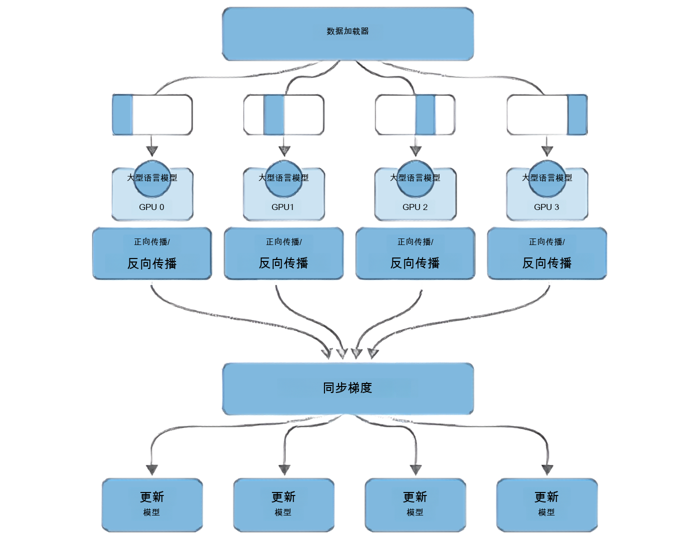

In [84]:
show_image(result)

In [ ]:
!aws s3 cp s3://sagemaker-us-west-2-687912291502/comfyui_output/images/0549ac24-62ab-4d4a-b9c1-c97e2aa96dbc.jpg ./

### 5 清除资源

* gui demo 

In [ ]:
!pip install gradio==4.44.1

In [ ]:
!python deploy_gui_async.py

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
account id:687912291502
sagemaker sdk version: 2.233.0
role:  arn:aws:iam::687912291502:role/service-role/AmazonSageMaker-ExecutionRole-20211013T113123  
bucket:  sagemaker-us-west-2-687912291502
Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://2c77f76773f8a715f2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
response = client.delete_endpoint(
    EndpointName=endpoint_name
    
)

response = client.delete_endpoint_config(
    EndpointConfigName=endpoint_config_name
)


print(f'终端节点:{endpoint_name} 已经被清除，请在控制台上查看状态')
